<a href="https://colab.research.google.com/github/bhanup6663/chest_x_ray_reporting/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchxrayvision
# !pip install langchain

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import os
import torch
import json
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
from segment_extraction import main as box_extraction
from cluster_extraction import main as cluster
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory
import matplotlib.pyplot as plt


Setting XRayResizer engine to cv2 could increase performance.


In [4]:
def get_cluster_description(cluster_id, file_path='cluster_descriptions.json'):
    with open(file_path, 'r') as file:
        clusters = json.load(file)

    for cluster in clusters:
        if cluster['cluster_id'] == cluster_id:
            return cluster['description']
    return "Cluster ID not found."

In [5]:
output_folder = 'output_folder'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [6]:
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
# def set_device():
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     return device

# device = set_device()
device='cpu'

In [8]:
tokenizer = AutoTokenizer.from_pretrained("Laim/Llama-3.1-MedPalm2-imitate-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("Laim/Llama-3.1-MedPalm2-imitate-8B-Instruct").to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
def preprocess_box(box, image_width, image_height):
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    position_x = x_min / image_width
    position_y = y_min / image_height
    box_center_x = (x_min + x_max) / 2
    box_center_y = (y_min + y_max) / 2

    return {
        "width": width,
        "height": height,
        "position_x": position_x,
        "position_y": position_y,
        "center_x": box_center_x,
        "center_y": box_center_y
    }

In [10]:
def generate_prompt(box_data, cluster_description):
    # Start with the bounding box findings from the image
    prompt = (
        "An X-ray image has been analyzed, and the following abnormalities were detected through object detection models:\n"
    )

    for entry in box_data:
        box_info = preprocess_box(entry['box'], 512, 512)  # Assuming the image is resized to 512x512
        prompt += (
            f"- **{entry['class_label']}**: Identified at approximately ({box_info['position_x']:.2f}, {box_info['position_y']:.2f}) "
            f"relative to the image size, with the bounding box centered at ({box_info['center_x']:.2f}, {box_info['center_y']:.2f}). "
            f"The bounding box dimensions are {box_info['width']}x{box_info['height']} pixels.\n"
        )

    # Add the unsupervised cluster analysis part after the bounding box details
    prompt += (
        "\nIn addition, this X-ray has been grouped into a cluster identified through unsupervised learning, "
        "which provides further context based on similar images in the dataset:\n"
        f"- **Clinical Relevance**: {cluster_description['clinical_relevance']}.\n"
        f"- **Cluster Distinction**: {cluster_description['cluster_distinction']}.\n\n"
    )

    # Conclude by asking for diagnostic insights based on the findings and analysis
    prompt += (
        "please provide a detailed medical report. Include potential diagnoses and clinical implications. "

    )

    return prompt


In [11]:
def process_predictions(image_path,fastercnn_model_path,kmeans_model_path,pca_model_path):

    predictions = box_extraction(image_path,fastercnn_model_path)
    cluster_number=cluster(image_path, kmeans_model_path, pca_model_path)
    cluster_description = get_cluster_description(cluster_number)
        # Generate prompt with bounding box information
    prompt = generate_prompt(predictions,cluster_description)
    return prompt

In [12]:
import re

In [13]:
def follow_up_response(prompt, memory):
    # Combine prompt with previous conversation history
    memory_variables = memory.load_memory_variables({})
    conversation_history = memory_variables.get('history', '')

    # Append history to the current question for context
    full_prompt = f"{conversation_history}\nHuman: {prompt}"

    # Generate response from model
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=760, temperature=0.15, top_p=0.9, repetition_penalty=1.2)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

    response = re.sub(r'([a-zA-Z])([,.!?;])', r'\1 \2', response)  # Add space between words and punctuation
    response = re.sub(r'([,.!?;])([a-zA-Z])', r'\1 \2', response)  # Add space after punctuation


    response = re.sub(r'([a-z])([A-Z])', r'\1 \2', response)  # Add space between words


    # Save the new conversation context (current prompt + response)
    memory.save_context({"input": prompt}, {"output": response})

    return response

In [14]:
image_path = '0b2cc81ad04ca2e91f2a8626b645cad8.png'
fastercnn_model_path='model_fasterRCNN_finetuned.pth'
kmeans_model_path = "kmeans_20_clusters.pkl"
pca_model_path = "pca_model.pkl"


In [15]:
prompt=process_predictions(image_path,fastercnn_model_path,kmeans_model_path, pca_model_path)

In [16]:
memory = ConversationBufferMemory()

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


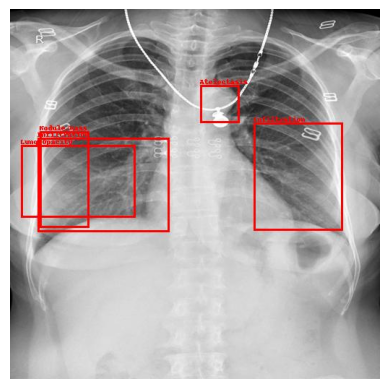

Initial Report:
 
Human: An X-ray image has been analyzed , and the following abnormalities were detected through object detection models:
- **Infiltration**: Identified at approximately (0.66, 0.31) relative to the image size , with the bounding box centered at (398.50, 231.50). The bounding box dimensions are 123x149 pixels .
- **Infiltration**: Identified at approximately (0.07, 0.35) relative to the image size , with the bounding box centered at (129.00, 243.00). The bounding box dimensions are 182x130 pixels .
- **Lung Opacity**: Identified at approximately (0.03, 0.37) relative to the image size , with the bounding box centered at (94.00, 238.00). The bounding box dimensions are 158x100 pixels .
- **Nodule/Mass**: Identified at approximately (0.08, 0.33) relative to the image size , with the bounding box centered at (75.00, 235.50). The bounding box dimensions are 68x133 pixels .
- **Atelectasis**: Identified at approximately (0.51, 0.21) relative to the image size , with the bou

In [17]:
initial_response = follow_up_response(prompt, memory)
display_image('/content/output_folder/predicted_image.jpg')
print("Initial Report:\n", initial_response)

In [18]:
follow_up_question = "Thank you !"

# Generate response to the follow-up question
follow_up_response_text = follow_up_response(follow_up_question, memory)
print("Follow-up Response:\n", follow_up_response_text)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Follow-up Response:
 Human: An X-ray image has been analyzed , and the following abnormalities were detected through object detection models:
- **Infiltration**: Identified at approximately (0.66, 0.31) relative to the image size , with the bounding box centered at (398.50, 231.50). The bounding box dimensions are 123x149 pixels .
- **Infiltration**: Identified at approximately (0.07, 0.35) relative to the image size , with the bounding box centered at (129.00, 243.00). The bounding box dimensions are 182x130 pixels .
- **Lung Opacity**: Identified at approximately (0.03, 0.37) relative to the image size , with the bounding box centered at (94.00, 238.00). The bounding box dimensions are 158x100 pixels .
- **Nodule/Mass**: Identified at approximately (0.08, 0.33) relative to the image size , with the bounding box centered at (75.00, 235.50). The bounding box dimensions are 68x133 pixels .
- **Atelectasis**: Identified at approximately (0.51, 0.21) relative to the image size , with the 